In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler

In [3]:
data = pd.read_csv("uber.csv")

1.Pre-process the dataset.

In [4]:
data = data.dropna()

In [5]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
Index: 199999 entries, 0 to 199999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Unnamed: 0         199999 non-null  int64  
 1   key                199999 non-null  object 
 2   fare_amount        199999 non-null  float64
 3   pickup_datetime    199999 non-null  object 
 4   pickup_longitude   199999 non-null  float64
 5   pickup_latitude    199999 non-null  float64
 6   dropoff_longitude  199999 non-null  float64
 7   dropoff_latitude   199999 non-null  float64
 8   passenger_count    199999 non-null  int64  
dtypes: float64(5), int64(2), object(2)
memory usage: 15.3+ MB
None


In [6]:
#Convert the 'pickup_datetime' column to a datetime object
data['pickup_datetime'] = pd.to_datetime(data['pickup_datetime'])

# Extract the date and time components into separate columns
data['pickup_date'] = data['pickup_datetime'].dt.date
data['pickup_time'] = data['pickup_datetime'].dt.time

In [7]:
data = data.drop(columns=['pickup_datetime'])
print(data[['pickup_date', 'pickup_time']])

       pickup_date pickup_time
0       2015-05-07    19:52:06
1       2009-07-17    20:04:56
2       2009-08-24    21:45:00
3       2009-06-26    08:22:21
4       2014-08-28    17:47:00
...            ...         ...
199995  2012-10-28    10:49:00
199996  2014-03-14    01:09:00
199997  2009-06-29    00:42:00
199998  2015-05-20    14:56:25
199999  2010-05-15    04:08:00

[199999 rows x 2 columns]


In [8]:
data['pickup_time_seconds'] = data['pickup_time'].apply(lambda x: x.hour * 3600 + x.minute * 60 + x.second)
# Convert 'pickup_time_seconds' to float
data['pickup_time_seconds'] = data['pickup_time_seconds'].astype(float)

In [9]:
data = data.drop(columns=['pickup_time'])

In [10]:
data = data.drop(columns=['key'])

In [11]:
data['pickup_date'] = pd.to_datetime(data['pickup_date'])

# Define a reference date (you can change this as needed)
reference_date = pd.Timestamp('2000-01-01')

# Calculate the difference in days between each date and the reference date
data['pickup_date'] = (data['pickup_date'] - reference_date).dt.days.astype(float)

2. Outliers

In [12]:
from scipy import stats

# Calculate the Z-scores for the 'fare_amount' column
data['z_score'] = stats.zscore(data['fare_amount'])

# Define a threshold for identifying outliers (e.g., 3)
threshold = 3

# Create a boolean mask to identify outliers
outliers_mask = (data['z_score'] > threshold) | (data['z_score'] < -threshold)

# Extract the outliers
outliers = data[outliers_mask]

# Print the outliers
print(outliers)


        Unnamed: 0  fare_amount  pickup_longitude  pickup_latitude   
48        22405517        56.80        -73.993498        40.764686  \
84        25485719        49.57        -73.975058        40.788820   
104       46435788        43.00        -73.862701        40.768959   
204        6403066        45.00        -73.971663        40.757812   
226       24085207        49.80        -73.992122        40.748577   
...            ...          ...               ...              ...   
199914    17686068        57.33        -73.776778        40.645427   
199972    31236221        45.00        -73.786833        40.639842   
199976     1780041        49.70        -73.978225        40.783318   
199977    21117828        43.50        -73.996671        40.737483   
199982    13096190        57.33        -73.969204        40.754771   

        dropoff_longitude  dropoff_latitude  passenger_count  pickup_date   
48             -73.993498         40.764686                1       4751.0  \
84   

In [13]:
data = data[~outliers_mask]
print(data)

        Unnamed: 0  fare_amount  pickup_longitude  pickup_latitude   
0         24238194          7.5        -73.999817        40.738354  \
1         27835199          7.7        -73.994355        40.728225   
2         44984355         12.9        -74.005043        40.740770   
3         25894730          5.3        -73.976124        40.790844   
4         17610152         16.0        -73.925023        40.744085   
...            ...          ...               ...              ...   
199995    42598914          3.0        -73.987042        40.739367   
199996    16382965          7.5        -73.984722        40.736837   
199997    27804658         30.9        -73.986017        40.756487   
199998    20259894         14.5        -73.997124        40.725452   
199999    11951496         14.1        -73.984395        40.720077   

        dropoff_longitude  dropoff_latitude  passenger_count  pickup_date   
0              -73.999512         40.723217                1       5605.0  \
1    

3.correlation_matrix

In [14]:
correlation_matrix = data.corr()
print(correlation_matrix)

                     Unnamed: 0  fare_amount  pickup_longitude   
Unnamed: 0             1.000000    -0.000381          0.000649  \
fare_amount           -0.000381     1.000000         -0.000925   
pickup_longitude       0.000649    -0.000925          1.000000   
pickup_latitude       -0.000741     0.001456         -0.811977   
dropoff_longitude      0.000625    -0.002646          0.832288   
dropoff_latitude      -0.000140     0.001663         -0.846307   
passenger_count        0.002658     0.011326         -0.000787   
pickup_date           -0.001252     0.132535          0.008925   
pickup_time_seconds    0.000538    -0.023549          0.002938   
z_score               -0.000381     1.000000         -0.000925   

                     pickup_latitude  dropoff_longitude  dropoff_latitude   
Unnamed: 0                 -0.000741           0.000625         -0.000140  \
fare_amount                 0.001456          -0.002646          0.001663   
pickup_longitude           -0.811977      

4.Implement linear regression and ridge, Lasso regression models

In [15]:
import matplotlib.pyplot as plt
X = data[["pickup_longitude", "pickup_latitude", "dropoff_longitude", "dropoff_latitude", "passenger_count"]]
y = data["fare_amount"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

Linear Regression RMSE: 6.403663896691127


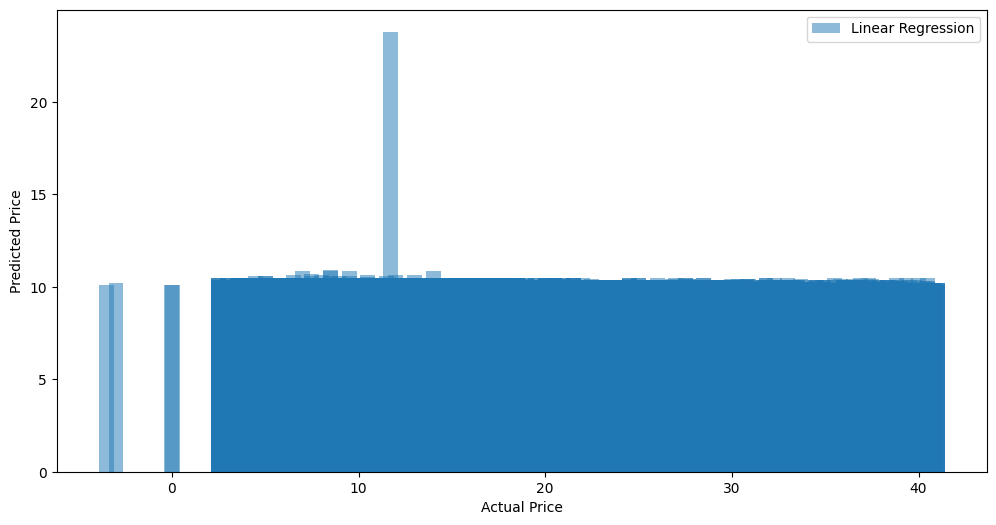

In [16]:
#Linear Regression
linear_reg = LinearRegression()
linear_reg.fit(X_train, y_train)
linear_pred = linear_reg.predict(X_test)
linear_rmse = mean_squared_error(y_test, linear_pred, squared=False)
print("Linear Regression RMSE:", linear_rmse)
plt.figure(figsize=(12, 6))
plt.bar(y_test, linear_pred, label='Linear Regression', alpha=0.5)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.legend()
plt.show()

Ridge Regression RMSE: 6.366206405948606


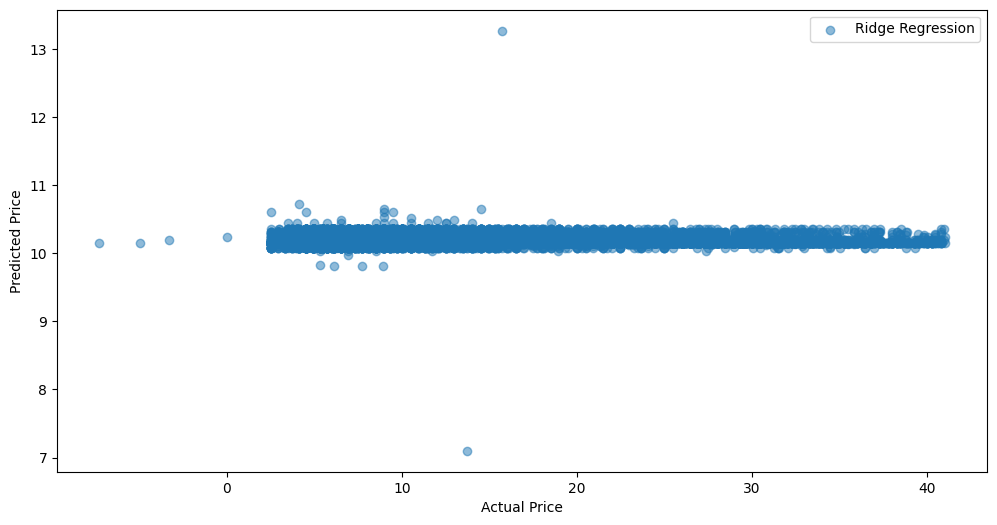

In [31]:
#Ridge Regression
ridge_reg = Ridge(alpha=1.0)
ridge_reg.fit(X_train, y_train)
ridge_pred = ridge_reg.predict(X_test)
ridge_rmse = mean_squared_error(y_test, ridge_pred, squared=False)
print("Ridge Regression RMSE:", ridge_rmse)
plt.figure(figsize=(12, 6))
plt.scatter(y_test, ridge_pred, label='Ridge Regression', alpha=0.5)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.legend()
plt.show()

Lasso Regression RMSE: 6.367045414644599


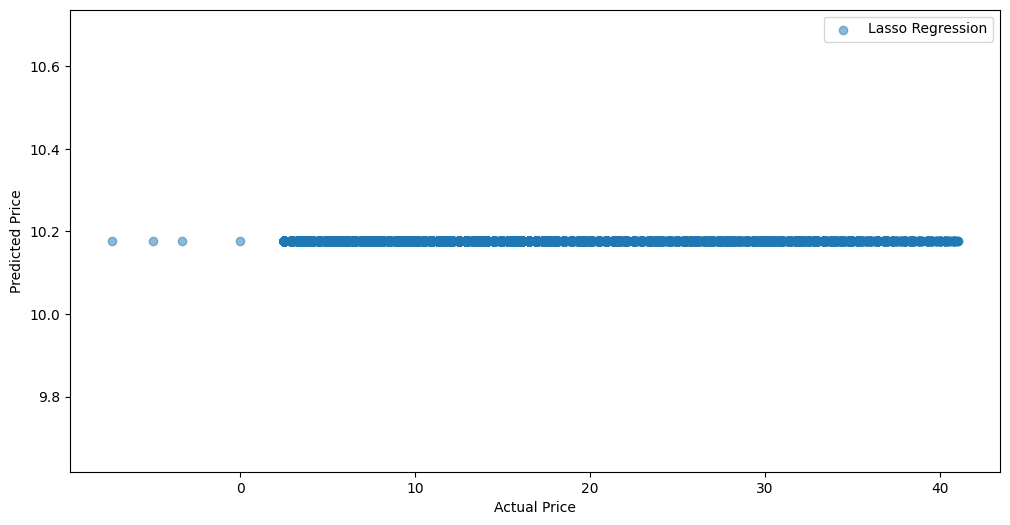

In [32]:
#Lasso Regression
lasso_reg = Lasso(alpha=1.0)
lasso_reg.fit(X_train, y_train)
lasso_pred = lasso_reg.predict(X_test)
lasso_rmse = mean_squared_error(y_test, lasso_pred, squared=False)
print("Lasso Regression RMSE:", lasso_rmse)
plt.figure(figsize=(12, 6))
plt.scatter(y_test, lasso_pred, label='Lasso Regression', alpha=0.5)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.legend()
plt.show()

5. Evaluate the models and compare their respective scores like R2, RMSE, etc

In [33]:
# Calculate R-squared (R2) scores
linear_r2 = r2_score(y_test, linear_pred)
ridge_r2 = r2_score(y_test, ridge_pred)
lasso_r2 = r2_score(y_test, lasso_pred)

# Calculate RMSE (Root Mean Squared Error)
linear_rmse = mean_squared_error(y_test, linear_pred, squared=False)
ridge_rmse = mean_squared_error(y_test, ridge_pred, squared=False)
lasso_rmse = mean_squared_error(y_test, lasso_pred, squared=False)

# Print the comparison of scores
print("R2 Scores:")
print("Linear Regression R2:", linear_r2)
print("Ridge Regression R2:", ridge_r2)
print("Lasso Regression R2:", lasso_r2)
print("\nRMSE Scores:")
print("Linear Regression RMSE:", linear_rmse)
print("Ridge Regression RMSE:", ridge_rmse)
print("Lasso Regression RMSE:", lasso_rmse)



R2 Scores:
Linear Regression R2: 0.00021185923607902613
Ridge Regression R2: 0.00021185860133488
Lasso Regression R2: -5.168491782692186e-05

RMSE Scores:
Linear Regression RMSE: 6.3662064039277215
Ridge Regression RMSE: 6.366206405948606
Lasso Regression RMSE: 6.367045414644599
